In [1]:
import cv2 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc 
import glob  
import imageio

#  Data Sampling

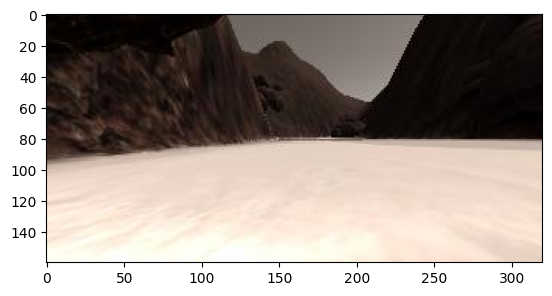

In [33]:
path = '../recorded_data/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Data sampling calibrated data

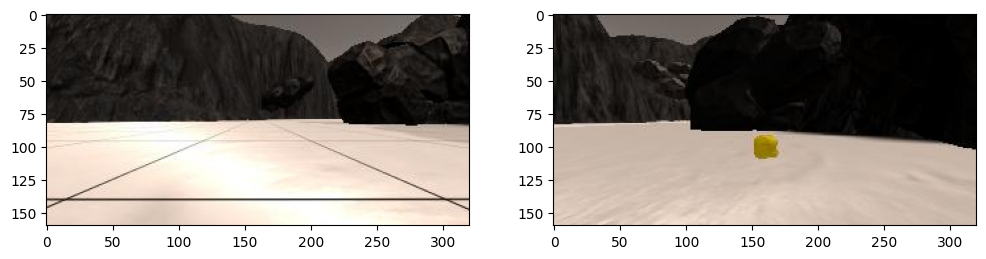

In [3]:
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

# Prespective transform
helps in maping image to real worldmap

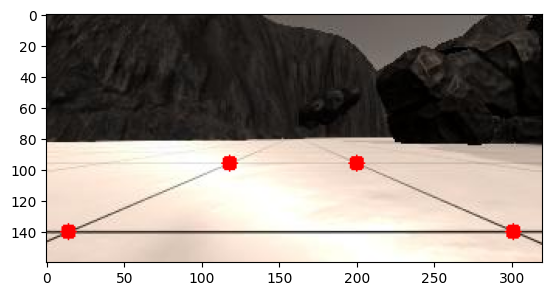

In [4]:
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

def mapPoints(img , points , color = (255,0,0)):
    img2 = img.copy()
    for point in points :
        cv2.circle(img2, tuple(point), 5, color, -1)
    return img2

illustrative_image = mapPoints(grid_img , source)
plt.imshow(illustrative_image) # show you how the source is choosen (red points is the source coordinates)

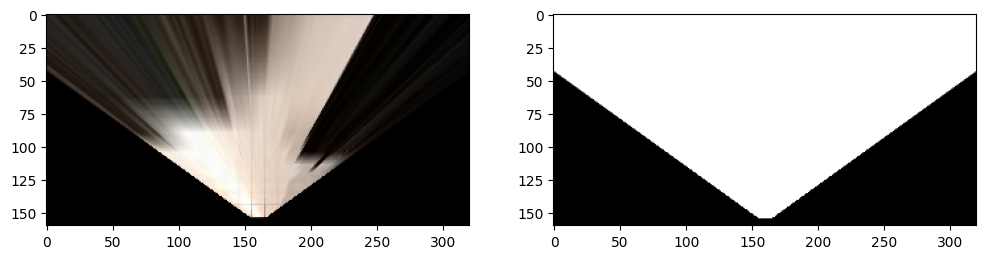

In [5]:
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    wraped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    mask = cv2.warpPerspective(np.ones((img.shape[0],img.shape[1])), M, (img.shape[1], img.shape[0]))# applying the same prespective transform to similar images filled with ones
    
    return wraped , mask


wraped , mask  = perspect_transform(grid_img,source,destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(wraped)
plt.subplot(122)
plt.imshow(mask,cmap='gray') # show the only area which have useful data

# Thresholding

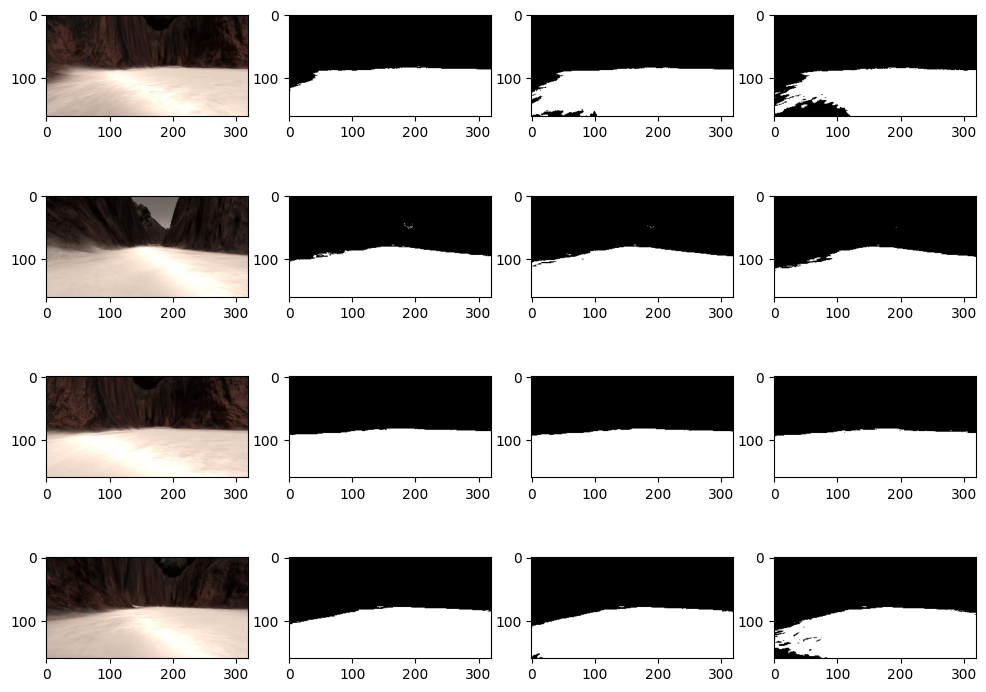

In [6]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# trying diffrent Thresholds (150,150,150) , (160, 160, 160) , (170, 170, 170) 
def testThreshSample(samples=4,threshs=[(150,150,150) , (160, 160, 160) , (170, 170, 170)]):
    np.random.seed(42)
    images = []
    thresh1 = []
    thresh2 = []
    thresh3 = []

    for i in range(0,4):
        idx = np.random.randint(0, len(img_list)-1)
        img = mpimg.imread(img_list[idx])
        images.append(img)
        thresh1.append(color_thresh(img,(150,150,150)))
        thresh2.append(color_thresh(img,(160, 160, 160)))
        thresh3.append(color_thresh(img,(170, 170, 170)))
    
    return images,thresh1,thresh2,thresh3

def getobstacles(threshed,mask):
    obstacles = np.absolute((np.float32(threshed)-1) * mask)
    return obstacles

images,thresh1,thresh2,thresh3 = testThreshSample()
fig = plt.figure(figsize=(12,9))
     
for i in range(len(images)):
    plt.subplot(4,4,i*4+1)
    plt.imshow(images[i])
    plt.subplot(4,4,i*4+2)
    plt.imshow(thresh1[i],cmap='gray')
    plt.subplot(4,4,i*4+3)
    plt.imshow(thresh2[i],cmap='gray')
    plt.subplot(4,4,i*4+4)
    plt.imshow(thresh3[i],cmap='gray')
# picking on random doesn't guarantee that (150,150,150) is the best threshold so i will try on manually choosen data 

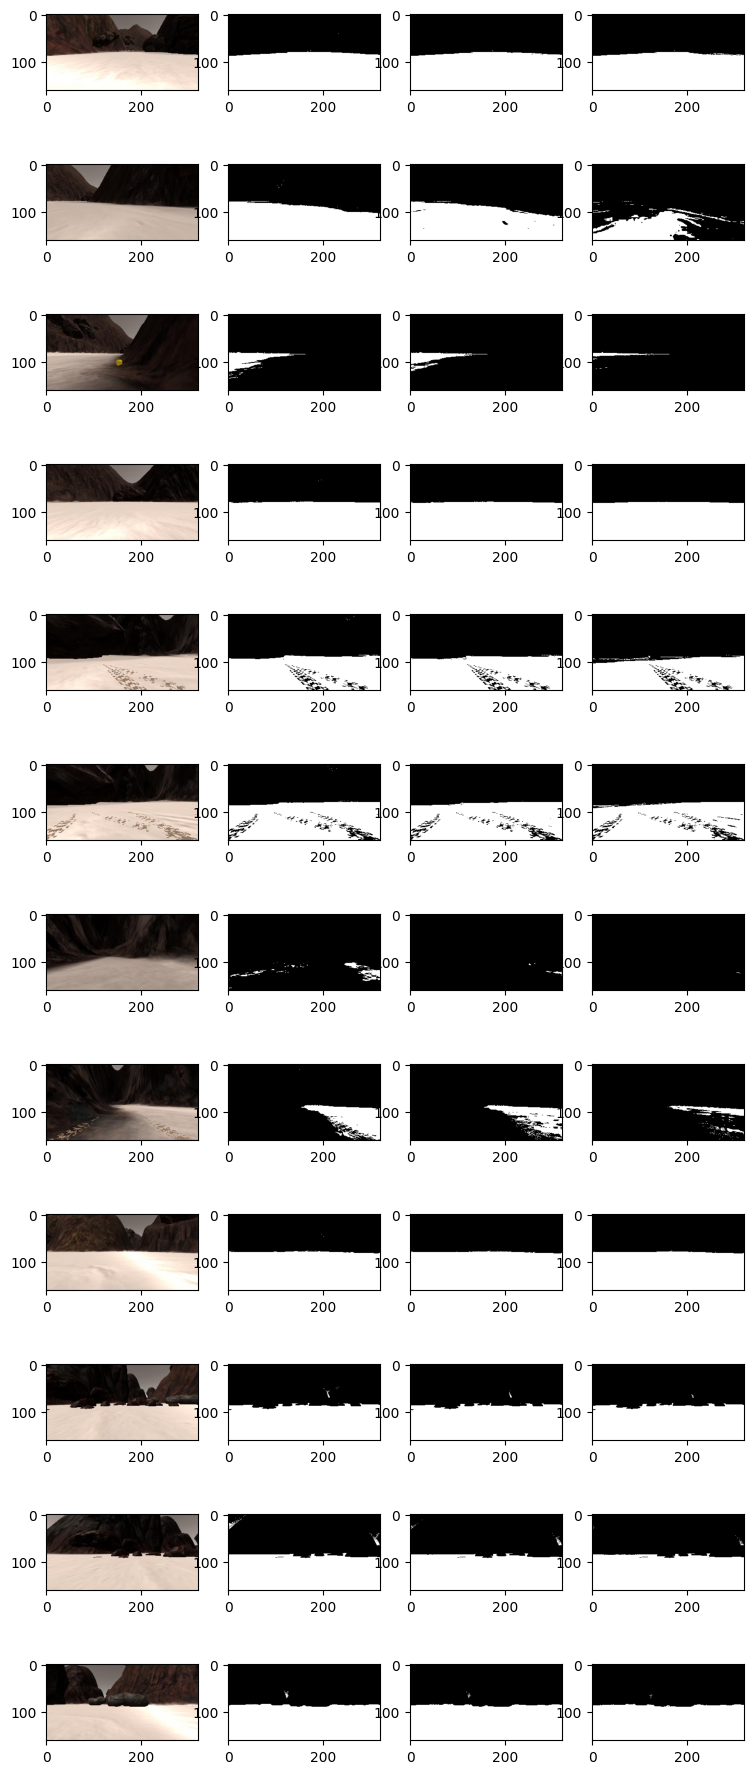

In [7]:
def testThresh(img,threshs=[(150,150,150) , (160, 160, 160) , (170, 170, 170)]):
    
    out = []
    for thresh in threshs :
        out.append(color_thresh(img,thresh))
    
    return out

def plot_threshs(path,threshs=[(150,150,150) , (160, 160, 160) , (170, 170, 170)]):
    img_list = glob.glob(path)
    fig = plt.figure(figsize=(9,25))
    for i in range(len(img_list)):
        image = mpimg.imread(img_list[i])
        plt.subplot(len(img_list)+1,4,i*4+1)
        plt.imshow(image)
        thresh1 , thresh2 , thresh3 = testThresh(image,threshs)
        plt.subplot(len(img_list)+1,4,i*4+2)
        plt.imshow(thresh1,cmap='gray')
        plt.subplot(len(img_list)+1,4,i*4+3)
        plt.imshow(thresh2,cmap='gray')
        plt.subplot(len(img_list)+1,4,i*4+4)
        plt.imshow(thresh3,cmap='gray')
    return img_list
path = '../recorded_data/thresholded_data/*'
img_list = plot_threshs(path)

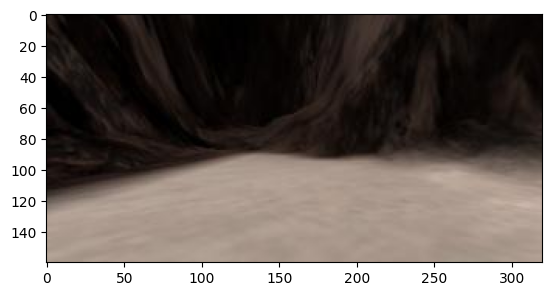

In [8]:
img_path = '../recorded_data/challenging/1.jpg' 
image = mpimg.imread(img_path)
plt.imshow(image)

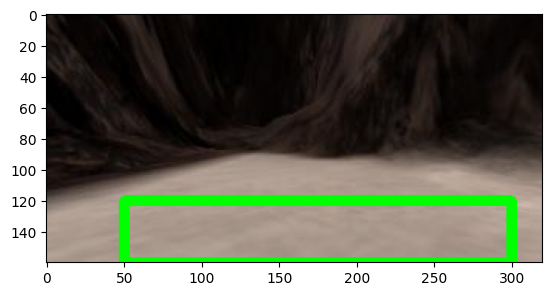

In [9]:
start_point = (50,120)
end_point = (300,160)
color = (0,255,0)
thickness = 5
copy = image.copy()
cv2.rectangle(copy, start_point, end_point, color, thickness)
plt.imshow(copy)

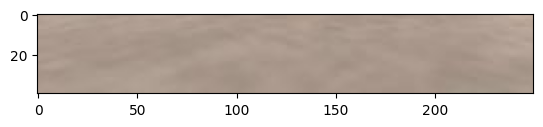

In [10]:
sample = image[start_point[1]:end_point[1],start_point[0]:end_point[0]]
plt.imshow(sample)

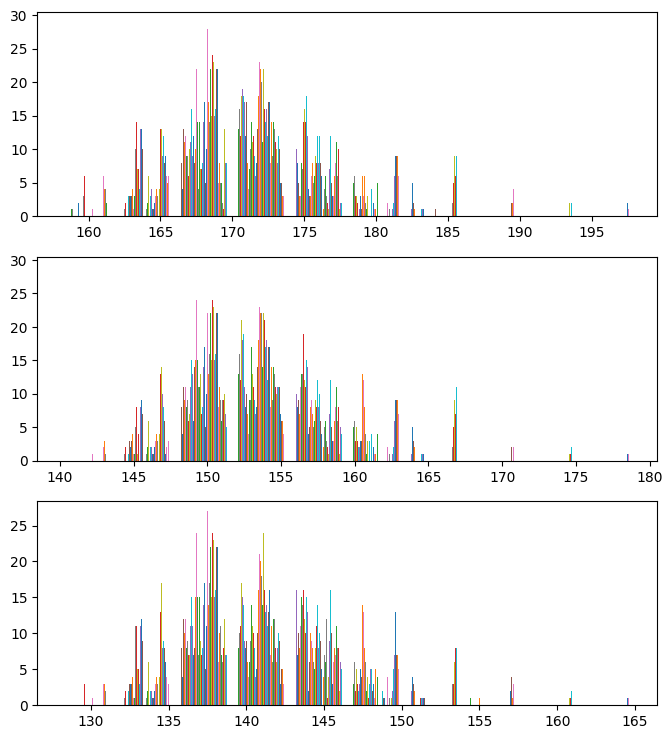

In [11]:
# we need to plot the histogram of each channel for this pixel to determine the right thresholding choice
fig = plt.figure(figsize=(8,9))
plt.subplot(3,1,1)
_ = plt.hist(sample[:,:,0])
plt.subplot(3,1,2)
_ = plt.hist(sample[:,:,1])
plt.subplot(3,1,3)
_ = plt.hist(sample[:,:,2])
# from histogram threshold on (B G R) , (155 , 140 , 127)

In [12]:
sample[:,:,0].min() , sample[:,:,1].min() , sample[:,:,2].min()

(158, 140, 128)

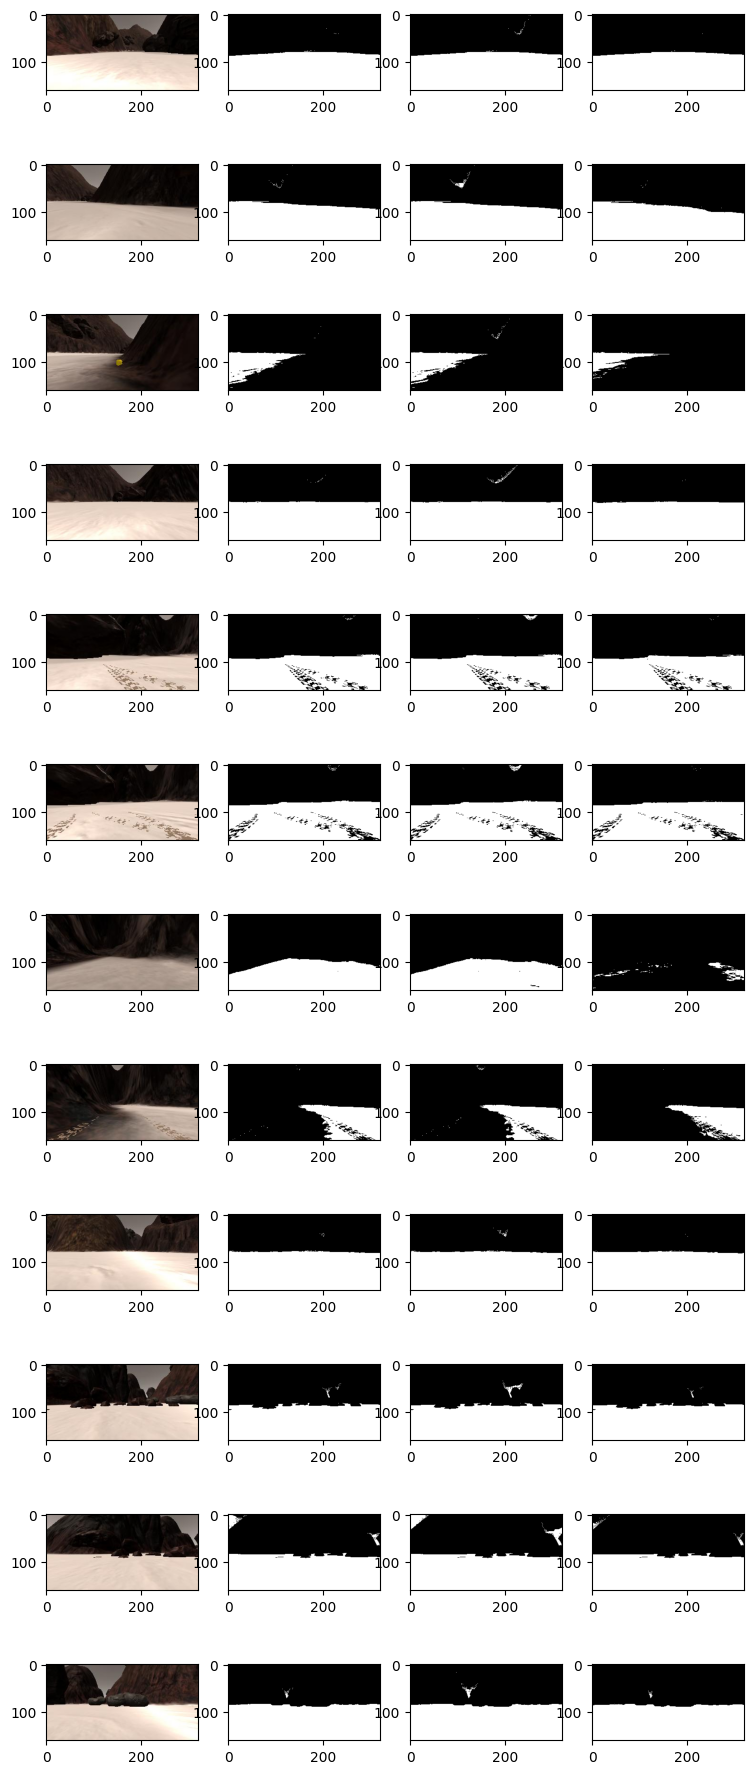

In [13]:
path = '../recorded_data/thresholded_data/*'
_ = plot_threshs(path,[(155 , 140 , 127),(130 , 130 , 130),(150 , 150 , 150)])

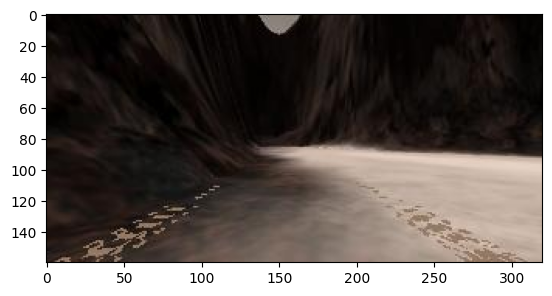

In [14]:
# path = '../recorded_data/challenging/2.jpg'
# img_list = glob.glob(path)
img_path = '../recorded_data/challenging/2.jpg'
image = mpimg.imread(img_path)
plt.imshow(image)

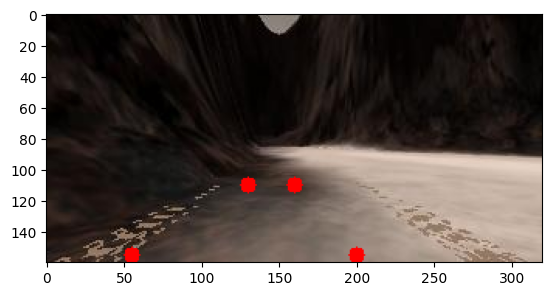

In [15]:
points = [(55,155),(130,110),(200,155),(160,110)]
maped = mapPoints(image,points)
plt.imshow(maped)

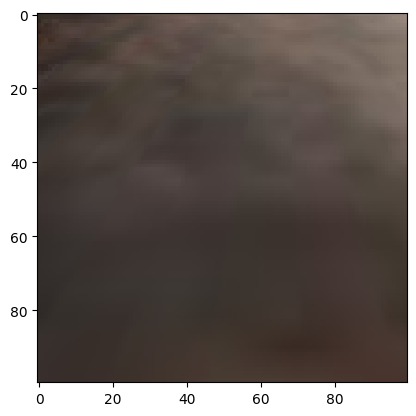

In [16]:
destination_thresh = [(0,0),(0,100),(100,0),(100,100)]
M = cv2.getPerspectiveTransform(np.float32(points),np.float32(destination_thresh))
transformed = cv2.warpPerspective(image, M, (100, 100))
plt.imshow(transformed)

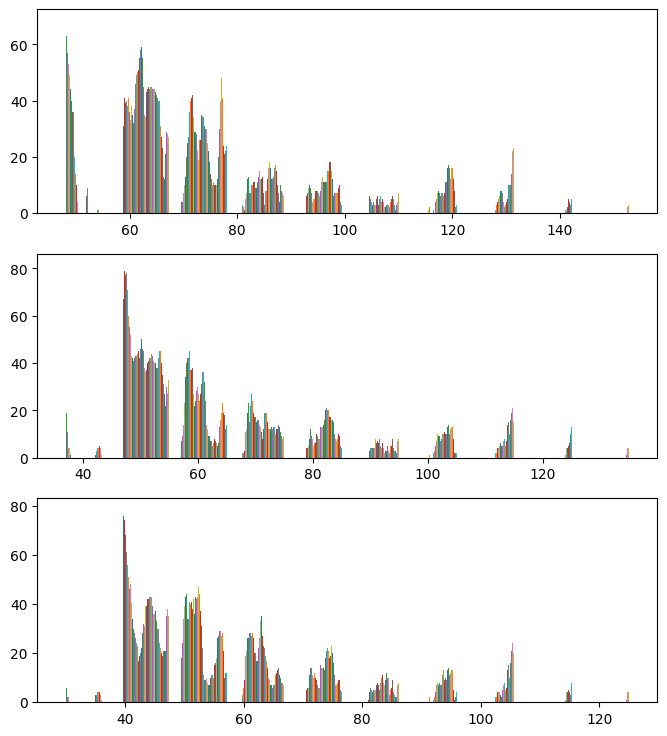

In [17]:
ig = plt.figure(figsize=(8,9))
plt.subplot(3,1,1)
_ = plt.hist(transformed[:,:,0])
plt.subplot(3,1,2)
_ =plt.hist(transformed[:,:,1])
plt.subplot(3,1,3)
_ =plt.hist(transformed[:,:,2])

In [18]:
transformed[:,:,0].min() , transformed[:,:,1].min() , transformed[:,:,2].min() # very low values better to neglect this case

(47, 36, 29)

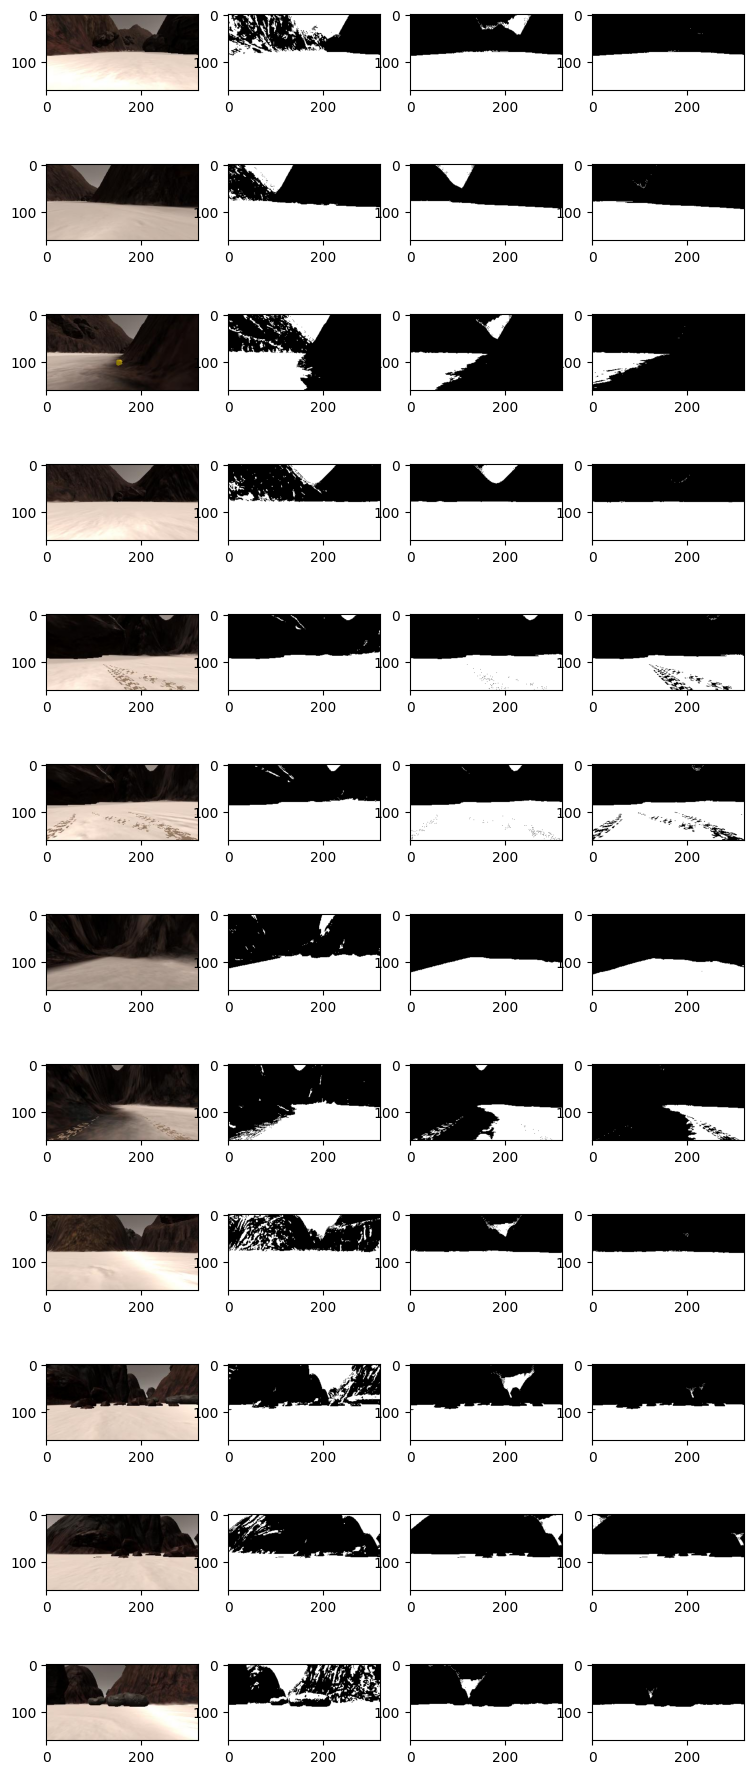

In [19]:
path = '../recorded_data/thresholded_data/*'
_ = plot_threshs(path,[(47, 36, 29) ,(120 , 100 , 90) , (155 , 140 , 127),])

## Try on with prespective transform

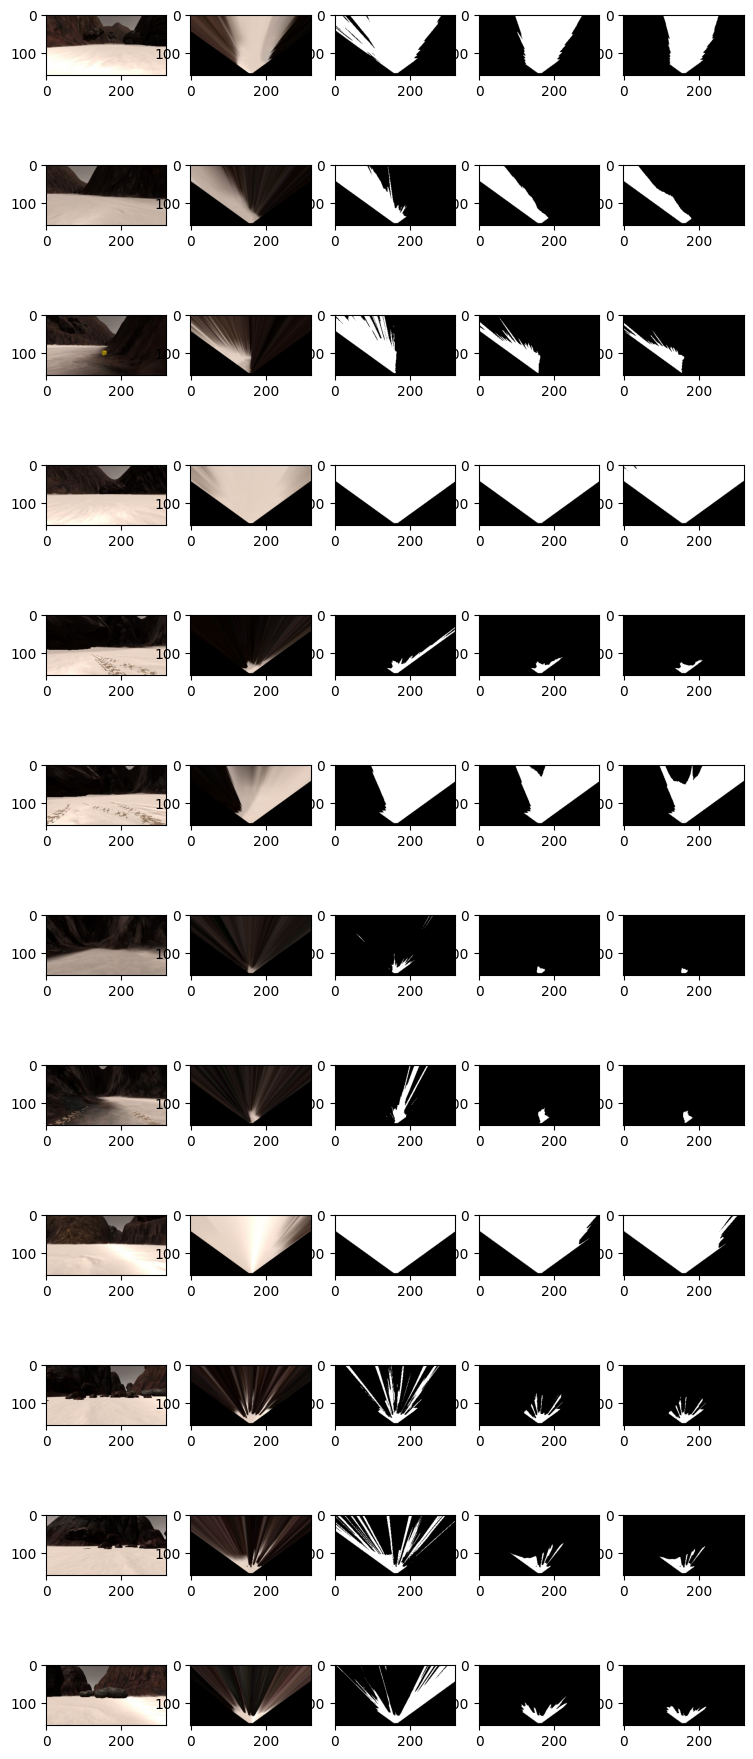

In [20]:
path = '../recorded_data/thresholded_data/*'
img_list = glob.glob(path)
fig = plt.figure(figsize=(9,25))
for i in range(len(img_list)):
    image = mpimg.imread(img_list[i])
    wraped , _  = perspect_transform(image,source,destination)
    plt.subplot(len(img_list)+1,5,i*5+1)
    plt.imshow(image)
    plt.subplot(len(img_list)+1,5,i*5+2)
    plt.imshow(wraped)
    thresh1 , thresh2 , thresh3 = testThresh(wraped,[(47, 36, 29) ,(120 , 100 , 90) , (155 , 140 , 127),])
    plt.subplot(len(img_list)+1,5,i*5+3)
    plt.imshow(thresh1,cmap='gray')
    plt.subplot(len(img_list)+1,5,i*5+4)
    plt.imshow(thresh2,cmap='gray')
    plt.subplot(len(img_list)+1,5,i*5+5)
    plt.imshow(thresh3,cmap='gray')


## Rocks

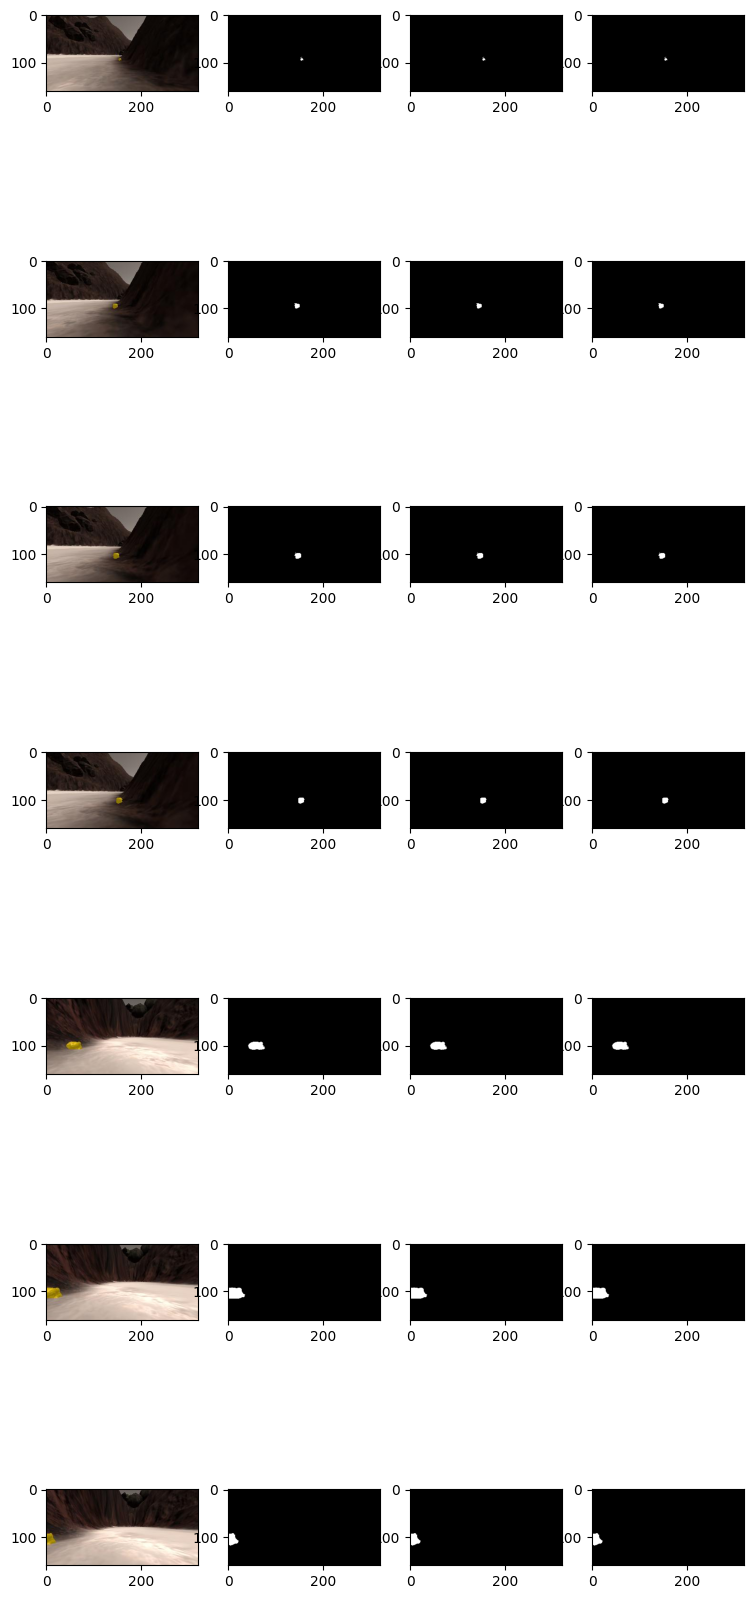

In [21]:
def color_thresh(img, rgb_thresh=(110, 110, 50)):
    # Create an array of zeros same xy size as img, but single channel
    lower_yellow = np.array([24-10,100,100])
    upper_yellow = np.array([24+10,255,255])

    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image to get only upper_yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Return the binary image
    return mask

path = '../recorded_data/rocks/*'
_ = plot_threshs(path) # rocks is easily detected in hsv

# Navigation

In [22]:
destination

array([[155., 154.],
       [165., 154.],
       [165., 144.],
       [155., 144.]], dtype=float32)

In [23]:
np.mean(destination,axis=0)

array([160., 149.], dtype=float32)

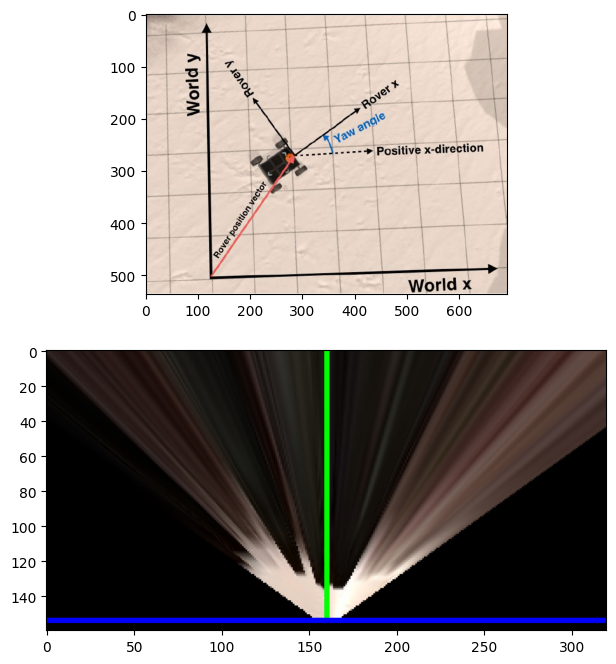

In [24]:
path = '../world axes.JPG'
image = mpimg.imread(path)
fig = plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(image) # so to map this picture to the wraped
plt.subplot(2,1,2)
axes = np.mean(destination,axis=0)
testimage = wraped.copy()
cv2.line(testimage, (axes[0],160-bottom_offset), (axes[0],0), (0,255,0), 2) # x-axis green axis
cv2.line(testimage, (0,160-bottom_offset), (image.shape[1]-1,160-bottom_offset), (0,0,255), 2) # y-axis blue axis
plt.imshow(testimage)

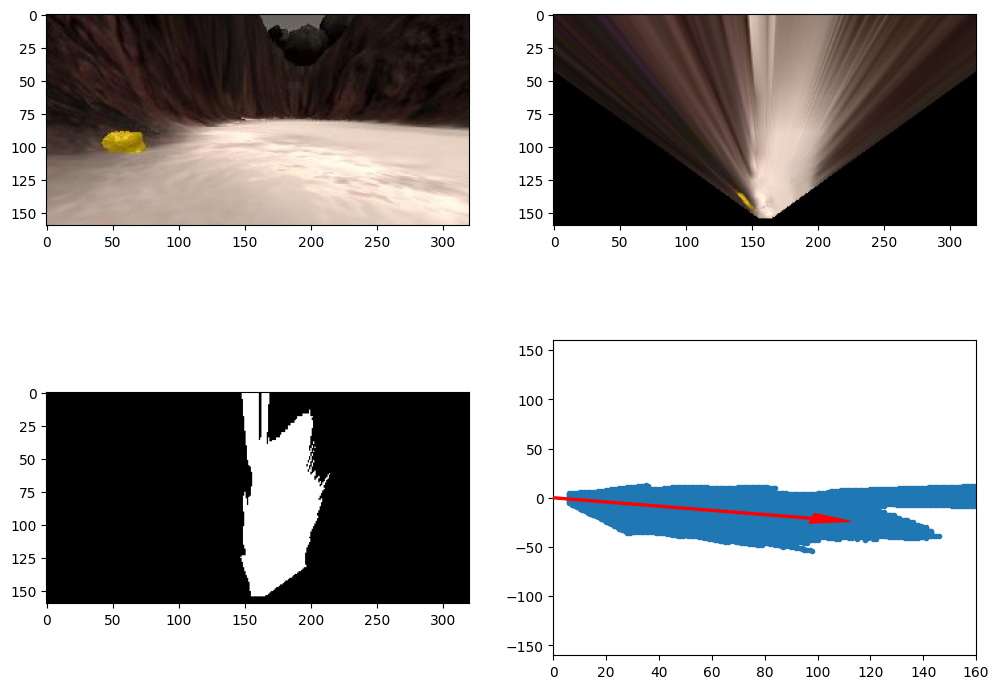

In [25]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero() # fliping x , and y as the are flipped here the x-axis is the vertiacl and y is the horizontal 
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# point the pixels in the direction of the rover using rover angle (yaw) 
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

# rescale the pixels ( maping pixels to meters) by dividing by 10 as every meter is 10 pixels by prespective transform , also add the current xpos , ypos to each pixel
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

path = '../recorded_data/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
fig = plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.imshow(image)
wraped , mask = perspect_transform(image,source,destination)
plt.subplot(2,2,2)
plt.imshow(wraped)
plt.subplot(2,2,3)
threshed = color_thresh(wraped,(155 , 140 , 127))
plt.imshow(threshed,cmap='gray')
x_pixel, y_pixel = rover_coords(threshed)
dist, angles = to_polar_coords(x_pixel, y_pixel)
mean_dir = np.mean(angles)
plt.subplot(2,2,4)
plt.plot(x_pixel,y_pixel,'.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=3, head_width=10, width=2)

# Writing to world map

In [26]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float) # covert from binary to rgb where green is the map

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

In [27]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

dst_size = 5 
bottom_offset = 6

source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
# destination = np.float32([[width/2 - dst_size, height - bottom_offset],
#                   [width/2 + dst_size, height - bottom_offset],
#                   [width/2 + dst_size, height - 2*dst_size - bottom_offset], 
#                   [width/2 - dst_size, height - 2*dst_size - bottom_offset],
#                   ])

scale = 2*dst_size

def color_rocks(img):
    # Create an array of zeros same xy size as img, but single channel
    lower_yellow = np.array([24-10,100,100])
    upper_yellow = np.array([24+10,255,255])

    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image to get only upper_yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Return the binary image
    return mask

def getangleImage(threshed):

    x_pix , y_pix = rover_coords(threshed)
    dist , angle = to_polar_coords(x_pix , y_pix)
    mean_dir = np.mean(angle)
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.plot(x_pix,y_pix,'.')
    ax.axis(xmin=0,xmax=160,ymin=-160,ymax=160)

    arrow_length = 100
    x_arrow = arrow_length * np.cos(mean_dir)
    y_arrow = arrow_length * np.sin(mean_dir)
    ax.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=3, head_width=10, width=2)
    ax.axis('off')
    ax.margins(0)
    canvas.draw()# draw the canvas, cache the renderer
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image_from_plot = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return cv2.resize(image_from_plot , dsize = (wraped.shape[0],wraped.shape[1])  , interpolation = cv2.INTER_AREA)

def locateTerrain(threshed_image,world_map):
    xpix, ypix = rover_coords(threshed_image)
    navigable_terrain_x , navigable_terrain_y = pix_to_world(xpix, ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count],data.worldmap.shape[0] , scale)
    world_map[navigable_terrain_x , navigable_terrain_y , 2] = 255
    return navigable_terrain_x , navigable_terrain_y

def locateObstacles(threshed_image,world_map):
    xpix, ypix = rover_coords(threshed_image)
    obstacles_x , obstacles_y = pix_to_world(xpix, ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count],data.worldmap.shape[0] , scale)
    world_map[obstacles_x , obstacles_y , 0] = 255
    world_map[ world_map[: , : , 2] > 0 ,0 ] = 0  
    return obstacles_x , obstacles_y


def locateRocks(threshed,world_map):
    xpix, ypix = rover_coords(threshed)
    rock_x , rock_y = pix_to_world(xpix, ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count],data.worldmap.shape[0] , scale)
    world_map[rock_x , rock_y , :] = 255
    return rock_x , rock_y


def process_image(img):
    
    output_image = np.zeros((img.shape[0] + 320 , img.shape[1]*2, 3))
    
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    warped,mask = perspect_transform(img, source, destination)
        
    threshed = color_thresh(warped,(155 , 140 , 127))
    obstacles = getobstacles(threshed,mask)
    rock_samples = color_rocks(warped)
    
    output_image[0:img.shape[0], img.shape[1]:] = warped
    
    
    xpix_navigable, ypix_navigable = rover_coords(threshed)
    xpix_obstacles, ypix_obstacles = rover_coords(obstacles)
    xpix_rocks, ypix_rocks = rover_coords(rock_samples)
    
    angle_image = getangleImage(threshed)
    output_image[img.shape[0]: , 0:angle_image.shape[1]] = angle_image
    
    
    scale = 2 * dst_size
    navigable_x_world, navigable_y_world = pix_to_world(xpix_navigable, ypix_navigable, 
                                                        data.xpos[data.count], data.ypos[data.count], 
                                                        data.yaw[data.count], data.worldmap.shape[0], scale)
    obstacle_x_world, obstacle_y_world = pix_to_world(xpix_obstacles, ypix_obstacles, 
                                                      data.xpos[data.count], data.ypos[data.count], 
                                                      data.yaw[data.count], data.worldmap.shape[0], scale)
    rock_x_world, rock_y_world = pix_to_world(xpix_rocks, ypix_rocks, 
                                              data.xpos[data.count], data.ypos[data.count], 
                                              data.yaw[data.count], data.worldmap.shape[0], scale)
    
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 10
    data.worldmap[rock_y_world, rock_x_world, 1] = 255
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 10
    # remove overlap mesurements
    nav_pix = data.worldmap[:,:,2] > 0
    data.worldmap[nav_pix, 0] = 0
    # clip to avoid overflow
    data.worldmap = np.clip(data.worldmap, 0, 255)
    
    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:img.shape[0]+data.worldmap.shape[0], image.shape[1]:image.shape[1]+data.worldmap.shape[1]] = np.flipud(map_add)

        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/test_mapping.mp4.
Moviepy - Writing video ../output/test_mapping.mp4



Moviepy - Done !
Moviepy - video ready ../output/test_mapping.mp4
Wall time: 19.4 s


In [32]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))